<a id="top"></a>
 <font size="5">Test Robust AR</font>
> 

> * Prepared by Alfredo López
> * alfredo.lopez@scch.at
> 
<hr>
<hr>

# Import

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pitsa
from sklearn.neighbors import KNeighborsRegressor

# Input

In [2]:
csv_file = '4_sinfcp'
correction_window = 80 # correction window size

# Folders

In [3]:
# Please enter the input data folder 
data_folder = '../../../2_data/processed/synthetic'

# Data

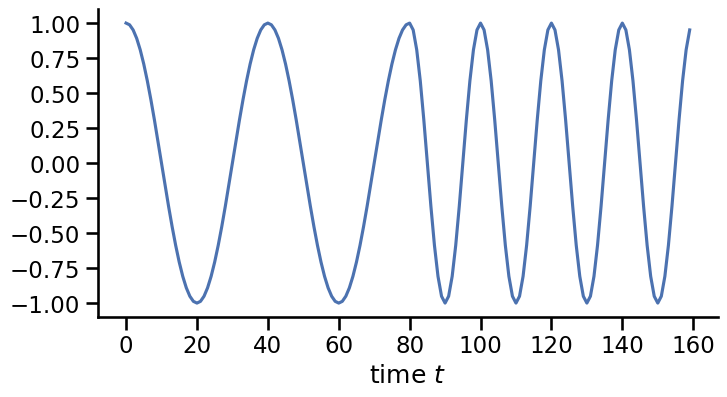

In [4]:
# time series reading
data_folder = '../../../2_data/processed/synthetic'
file_name = os.path.join(data_folder, csv_file + '.csv')
df = pd.read_csv(file_name, index_col='t')

# plot
with sns.plotting_context("talk"):
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax = sns.lineplot(data=df, x='t', y='y', ax=ax)
    ax.set_xlabel(r'time $t$')
    ax.set_ylabel('')
    sns.despine()

# Time-domain bapc

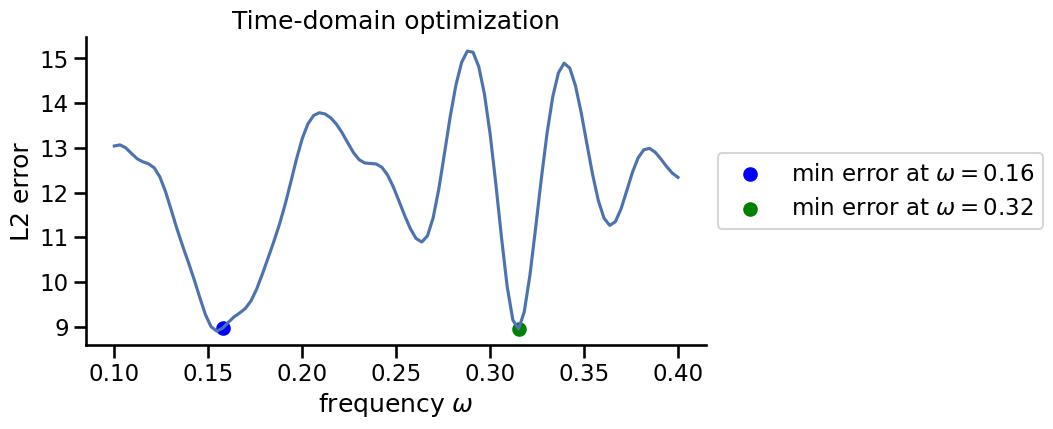

In [5]:
def sinusoidal(t, alpha, beta, omega, phi):
    return alpha*np.exp(-beta*t) * np.cos(omega*t + phi)

t = df.index.values
alpha = 1
beta = 0
omega_left = 2 * np.pi / 40
omega_right = 2 * np.pi / 20
omega = np.linspace(0.1, 0.4, 100)
omega0 = omega.copy()
phi = 0

omega, t = np.meshgrid(omega, t)
y = sinusoidal(t, alpha, beta, omega, phi)

error = y-df.values
l2_error = np.linalg.norm(error, axis=0)

# plot
with sns.plotting_context("talk"):
    plt.figure(figsize=(8, 4))
    ax = plt.gca()
    plt.plot(omega0, l2_error)
    ax.set_xlabel(r'frequency $\omega$')
    ax.set_ylabel('L2 error')

    # Add marker at x=omega_left and y equals to the associated l2_error
    omega_left_index = np.argmin(np.abs(omega0 - omega_left))
    omega_left_value = omega0[omega_left_index]
    l2_error_value = l2_error[omega_left_index]
    plt.scatter(omega_left_value, l2_error_value, color='blue', label=r'min error at $\omega={:.2f}$'.format(omega_left_value))

    # Add marker at x=omega_right and y equals to the associated l2_error
    omega_right_index = np.argmin(np.abs(omega0 - omega_right))
    omega_right_value = omega0[omega_right_index]
    l2_error_value = l2_error[omega_right_index]
    plt.scatter(omega_right_value, l2_error_value, color='green', label=r'min error at $\omega={:.2f}$'.format(omega_right_value))
    plt.title('Time-domain optimization')

    # legend outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    sns.despine()

# BAPC with Sinusoidal

In [6]:
# sinusoidal base model
period = 40
frequency = 2*np.pi/period
params_init = {'frequency': frequency, 'phase':0.0}
params_fixed = {'intercept': 0.0, 'amplitude':1.0}
fit_args = {'params_init': params_init, 'params_fixed': params_fixed}
base_model = pitsa.models.regression.Cosine(fit_args=fit_args)

model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')

# intialize
explainer = pitsa.xai.bapc.Explainer(
base_model=base_model, 
correction_model=correction_model
)

# train data
y_train = df
t = y_train.index.values
y = y_train.values.flatten()

# update
explainer.update(t=t, y=y, correction_window=correction_window, fit_residual=True)
display(explainer.get_params_as_df())

,intercept_before,amplitude_before,frequency_before,phase_before,intercept_after,amplitude_after,frequency_after,phase_after,intercept_delta,amplitude_delta,frequency_delta,phase_delta
time,,,,,,,,,,,,
159,0.0,1.0,0.151638,0.24848,0.0,1.0,0.152578,0.157133,0.0,0.0,-0.00094,0.091347


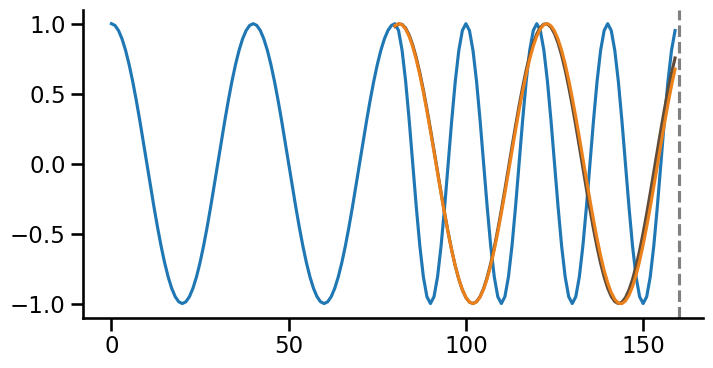

In [7]:
n_train = len(y_train)
t_prime = n_train - 1 # last training sample
h = 1 # forecast horizon
t_test = t_prime + h # forecast time

# simple plot
with sns.plotting_context("talk"):
    ax = explainer.plot(figsize=(8, 4)) 
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=6)
    ax.axvline(x=t_test, color='gray', linestyle='--')
    sns.despine()

# AR-domain domain bapc

In [8]:
#fit_args = {'robust':81}
fit_args = {'robust':False}
base_model = pitsa.models.timeseries.RobustAutoRegressive(fit_args=fit_args)

model = KNeighborsRegressor(n_neighbors=1) #Set n_neighbors=1 for perfect fit
correction_model = pitsa.models.regression.SKLearnModel(model, name='1NN')

# intialize
explainer = pitsa.xai.bapc.Explainer(
base_model=base_model, 
correction_model=correction_model
)

# train data
y_train = df
t = y_train.index.values
y = y_train.values.flatten()

# update
explainer.update(t=t, y=y, correction_window=correction_window, fit_residual=True)
display(explainer.get_params_as_df())

,ar.L1_before,ar.L2_before,ar.L1_after,ar.L2_after,ar.L1_delta,ar.L2_delta
time,,,,,,
159,1.932069,-0.992225,1.876146,-0.915042,0.055922,-0.077183


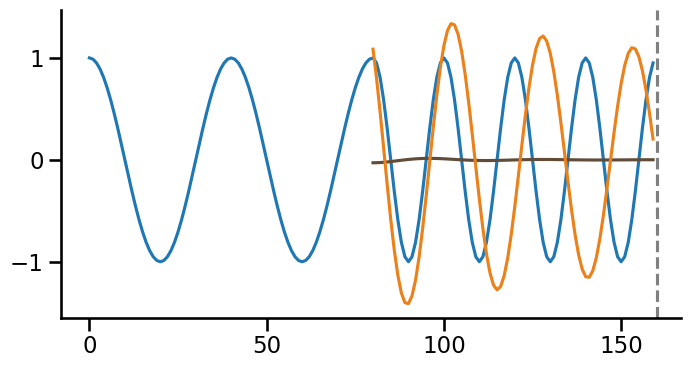

In [9]:
t_prime = n_train - 1 # last training sample
h = 1 # forecast horizon
t_test = t_prime + h # forecast time

# simple plot
with sns.plotting_context("talk"):
    ax = explainer.plot(figsize=(8, 4)) 
    plt.locator_params(axis='x', nbins=5)
    plt.locator_params(axis='y', nbins=6)
    ax.axvline(x=t_test, color='gray', linestyle='--')
    sns.despine()


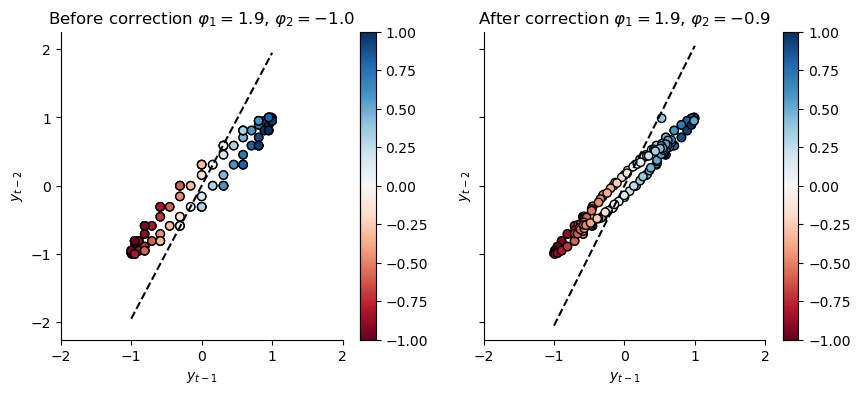

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

s = pd.Series(explainer.y)
s1 = s.shift(1)
s2 = s.shift(2)
ax1.scatter(s1, s2, c=s, cmap=plt.cm.RdBu, edgecolors='k')
cb = plt.colorbar(ax1.collections[0], ax=ax1)
ax1.set_xlabel(r'$y_{t-1}$')
ax1.set_ylabel(r'$y_{t-2}$')


phi1 = explainer.first_base_model.params['ar.L1']
phi2 = explainer.first_base_model.params['ar.L2']
x = np.linspace(-1, 1, 100)
ax1.plot(x, -phi1*x/phi2, 'k--')
ax1.set_title(r'Before correction $\varphi_1={:.1f}$, $\varphi_2={:.1f}$'.format(phi1, phi2))
ax1.set_xlim(-2, 2)

s = pd.Series(explainer.y_modified.flatten())
s1 = s.shift(1)
s2 = s.shift(2)
ax2.scatter(s1, s2, c=s, cmap=plt.cm.RdBu, edgecolors='k')
cb = plt.colorbar(ax2.collections[0], ax=ax2)
ax2.set_xlabel(r'$y_{t-1}$')
ax2.set_ylabel(r'$y_{t-2}$')

phi1 = explainer.second_base_model.params['ar.L1']
phi2 = explainer.second_base_model.params['ar.L2']
x = np.linspace(-1, 1, 100)
ax2.plot(x, -phi1*x/phi2, 'k--')
ax2.set_title(r'After correction $\varphi_1={:.1f}$, $\varphi_2={:.1f}$'.format(phi1, phi2))

sns.despine()